In [2]:
import datetime as dt   
from datetime import date
import random 
import numpy as np
                                                                                          
import pandas as pd                                                                                           

import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import yfinance as yf
import bt 

In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import datetime as dt

class indicators(object): 

    def sma(price, dates, N = 14):
        SMA = price.rolling(N).mean().fillna(price)

        return SMA

    def ema(price, dates, N = 14):
        EMA = price.ewm(span=N, adjust=False).mean()

        return EMA

    def price_sma_ratio(price, dates, N = 14):
        SMA = price.rolling(N).mean().fillna(price)
        price_SMA_ratio = price/SMA

        return price_SMA_ratio


    def price_ema_ratio(price, dates, N = 14):
        EMA = price.ewm(span=N, adjust=False).mean()
        price_EMA_ratio = price/EMA

        return price_EMA_ratio

In [4]:
def get_data(ticker, start_date, end_date):
    
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    stock_data[ticker] = stock_data['Adj Close']
    
    return stock_data[[ticker]]

def benchmark_trade(  		  	   		     		  		  		    	 		 		   		 		  
    sd, ed, symbol, max_holdings  		  	   		     		  		  		    	 		 		   		 		  
):  
    price = get_data(ticker, sd, ed).dropna()
    date_idx = price.index  		  	   		     		  		  		    	 		 		   		 		  
    orders = pd.DataFrame(index=date_idx)
    orders['price']=price
    orders[symbol] = 0  		  	   		     		  		  		    	 		 		   		 		  
    orders[symbol][0] = max_holdings  		  	   		     		  		  		    	 		 		   		 		  
    orders[symbol][-1] = -max_holdings  
    orders['trade'] = orders[symbol]
    return orders.fillna(0)

def get_stats(port_val):  		  	   		     			  		 			 	 	 		 		 	 		 		 	 		  	 	 			  	 
    daily_rets = (port_val / port_val.shift(1)) - 1  		  	   		     			  		 			 	 	 		 		 	 		 		 	 		  	 	 			  	 
    daily_rets = daily_rets[1:]
    cum_ret = (port_val.iloc[-1] / port_val.iloc[0]) - 1
    avg_ret = daily_rets.mean()  		  	   		     			  		 			 	 	 		 		 	 		 		 	 		  	 	 			  	 
    std_ret = daily_rets.std()  		  	   		     			  		 			 	 	 		 		 	 		 		 	 		  	 	 			  	 

    return cum_ret, avg_ret, std_ret 

def compute_portvals( 		  	   		     		  		  		    	 		 		   		 		  
    trade_df,  		  	   		     		  		  		    	 		 		   		 		  
    start_val=100000,  		  	   		     		  		  		    	 		 		   		 		  
    commission=0,  		  	   		     		  		  		    	 		 		   		 		  
    impact=0,  		  	   		     		  		  		    	 		 		   		 		  
):  		  	   		     		  		  		    	 		 		   		 		  

    df = trade_df
    df = trade_df.stack().reset_index()
    df.columns=['Date', 'Symbol', 'Trade']
    df['Order'] = np.where(df.Trade>0, 'BUY' , np.where(df.Trade<0, 'SELL', 'HOLD'))
    df['Shares']=abs(df.Trade)


    start_date = df.Date.min()
    end_date = df.Date.max()
    symbols= df.Symbol.unique()
    portvals = get_data(ticker, sd, ed).dropna()
    portvals = portvals[symbols] 

    record=df.sort_values('Date').copy()
    record['transaction_share']=np.where(record['Order']=='BUY',record['Shares'], -record['Shares'])
    record['transaction_cash']= record.apply(lambda row: -portvals.loc[row['Date'],row['Symbol']] * row['transaction_share'], axis=1)
    record['transaction_cost']= - commission *(record['Trade']!=0) - abs(record['transaction_cash'])*impact

    df2 = record[['Date','Symbol','transaction_share','transaction_cash','transaction_cost'
                 ]].pivot_table(index='Date', columns='Symbol', values=['transaction_share','transaction_cash','transaction_cost'], aggfunc='sum')
    df2.columns = ['_'.join(col).strip() for col in df2.columns.values]
    df2=df2.fillna(0).copy()

    cols_cash=df2.columns[df2.columns.str.startswith('transaction_cash')|df2.columns.str.startswith('transaction_cost')]
    df2['cash']=df2[cols_cash].sum(axis=1)
    df2=df2.drop(columns=cols_cash)
    df2.loc[df2.index==start_date,'cash']=start_val+df2.loc[df2.index==start_date,'cash']
    df_cumsum=df2.cumsum().join(portvals, how='right').fillna(method='ffill')

    df_cumsum['equity_value']=0.0
    for s in symbols:
        equity_value = df_cumsum['transaction_share_'+s]*df_cumsum[s]
        df_cumsum['equity_value']=df_cumsum['equity_value']+equity_value
    df_cumsum['closing_value']=df_cumsum[['cash','equity_value']].sum(axis=1)

    portvals = df_cumsum[['closing_value']]

    return portvals    

In [5]:
def get_portvals(temp, start_val, trade_col_name='trade'):
    for idx, row in temp.iterrows():
        if idx == temp.index[0]:
            prev_row = row
            row['cash'] = sv
            row['quantity'] = 0
            

        if row[trade_col_name] == 0:
            # do nothing
            row['cash'] = prev_row['cash']
            row['quantity'] = prev_row['quantity']

        elif row[trade_col_name] == 1:
            # buy, no more cash
            row['quantity'] = prev_row['cash'] / row['price']
            row['cash'] = 0

        elif row[trade_col_name] == -1:
            # sell, no more stock
            row['cash'] = prev_row['quantity'] * row['price']
            row['quantity'] = 0

        temp.at[idx, 'cash'] = row['cash']
        temp.at[idx, 'quantity'] = row['quantity']
        prev_row = row
        # result = result.append(row)

    temp = temp.copy()
    temp['stock_value'] = temp['quantity'] * temp['price']
    temp['closing_value']= temp['stock_value'] + temp['cash']
    
    return temp

In [6]:
class ManualStrategy(object):  		  	   		     		  		  		    	 		 		   		 		  
    # constructor  		  	   		     		  		  		    	 		 		   		 		  
    def __init__(self, verbose=False, impact=0.0, commission=0.0):  		  	   		     		  		  		    	 		 		   		 		  
        """  		  	   		     		  		  		    	 		 		   		 		  
        Constructor method  		  	   		     		  		  		    	 		 		   		 		  
        """  		  	   		     		  		  		    	 		 		   		 		  
        self.verbose = verbose  		  	   		     		  		  		    	 		 		   		 		  
        self.impact = impact  		  	   		     		  		  		    	 		 		   		 		  
        self.commission = commission  		  	   		     		  		  		    	 		 		   		 		   
        
    def get_sample(self, syms, sd,  ed):
        dates = pd.date_range(sd, ed)  		  	   		     		  		  		    	 		 		   		 		    
        prices = get_data(ticker, sd, ed).dropna()

        price_norm = (prices/prices.iloc[0])[syms]
        dates = prices.index
        price_norm['return'] = price_norm[syms].shift(-1)/price_norm[syms]-1
        price_norm = price_norm.fillna(0)

        price = price_norm[syms[0]]

        id_x = pd.DataFrame()
        id_x['ema20'] = indicators.ema(price=price, dates=dates, N=20)
        id_x['ema50'] = indicators.ema(price=price, dates=dates, N=50)
        id_x['ema100'] = indicators.ema(price=price, dates=dates, N=100)

        id_x['price_to_ema20'] = indicators.price_ema_ratio(price=price, dates=dates, N=20)
        id_x['price_to_ema50'] = indicators.price_ema_ratio(price=price, dates=dates, N=50)
        id_x['price_to_ema100'] = indicators.price_ema_ratio(price=price, dates=dates, N=100)

        id_x['sma20'] = indicators.sma(price=price, dates=dates, N=20)
        id_x['sma50'] = indicators.sma(price=price, dates=dates, N=50)
        id_x['sma200'] = indicators.sma(price=price, dates=dates, N=200)

        id_x['price_to_sma20'] = indicators.price_sma_ratio(price=price, dates=dates, N=20)
        id_x['price_to_sma50'] = indicators.price_sma_ratio(price=price, dates=dates, N=50)
        id_x['price_to_sma200'] = indicators.price_sma_ratio(price=price, dates=dates, N=200)

        id_x = id_x.fillna(method='bfill')

        id_x['price'] = prices[syms]
        id_x['price_diff'] = prices[syms].shift(-1) - prices[syms] 
        id_x['return'] = price_norm['return']
        id_x['current_holding'] = 0
        id_x['trade'] = 0
        id_x['action'] = 0
        
        self.id_x = id_x

        return id_x.fillna(0)

    # this method buy all or sell all, position indicates how hold or sell
    def testPolicy(  		  	   		     		  		  		    	 		 		   		 		  
        self,  		  	   		     		  		  		    	 		 		   		 		  
        symbol="",  		  	   		     		  		  		    	 		 		   		 		  
        sd=dt.datetime(2009, 1, 1),  		  	   		     		  		  		    	 		 		   		 		  
        ed=dt.datetime(2010, 1, 1),  		  	   		     		  		  		    	 		 		   		 		  
        sv=10000, 
        policy = 'sma200',
    ):  		  	   		     		  		  		    	 		 		   		 		  
        
        syms = [symbol]
        id_x = self.get_sample(syms, sd- timedelta(days=200),  ed)
        commission = self.commission
        impact = self.impact

        if policy == 'sma200':
        
            # buy signal
            condition1 = (id_x['price_to_sma200']>1.05)
            # sell signal
            condition2 = (id_x['price_to_sma200']<0.95)

            id_x['signal'] = np.where(condition1, 1,np.where(condition2, -1, 0))
            id_x['position'] = np.where(id_x['signal']==1, 1, np.where(id_x['signal']==-1, 0, np.nan)) # using 1 or 0 to represent holding all or selling all
            id_x['position'] = id_x['position'].fillna(method='ffill')#.astype(str)

        if policy == 'ema20':
        
            # buy signal
            condition1 = (id_x['ema20']>=id_x['ema100']) & (id_x['ema20']>=id_x['ema50'])
            # sell signal
            condition2 = (id_x['price_to_sma200']<0.95)

            id_x['signal'] = np.where(condition1, 1,np.where(condition2, -1, 0))
            id_x['position'] = np.where(id_x['signal']==1, 1, np.where(id_x['signal']==-1, 0, np.nan))
            id_x['position'] = id_x['position'].fillna(method='ffill')#.astype(str)
        
        id_x['trade']=id_x['position'].diff().fillna(id_x['position'])        
    
        #trade_df = id_x[['trade']].rename(columns={'trade':symbol})
        #trade_df.iloc[-1] = 0-trade_df.sum()
        
        #trade_df['price_to_sma200'] = id_x['price_to_sma200']

        return id_x.fillna(0)

In [7]:
symbol = "QQQ"
ticker = "QQQ"
sd=dt.datetime(2002, 1, 1)
ed=dt.datetime(2010, 1, 1)
commission = 0
impact = 0
sv = 100000
verbose = False
trade_col_name='trade'

bm_trade_os = benchmark_trade(  
        symbol=symbol,  		  	   		     		  		  		    	 		 		   		 		  
        sd=sd,  		  	   		     		  		  		    	 		 		   		 		  
        ed=ed,  		  	   		     		  		  		    	 		 		   		 		   
        max_holdings=1  		  	   		     		  		  		    	 		 		   		 		  
)
#bm_port_val_os = compute_portvals(bm_trade_os,  start_val=sv, commission=commission,  impact=impact)
bm_port_val_os = get_portvals(bm_trade_os,  start_val=sv, trade_col_name='trade')#, commission=commission,  impact=impact)


rc, ar, sr = get_stats(bm_port_val_os['closing_value'])
print("""Performance of Benchmark: 
cumulative return:{:.2%}, 
average of daily return:{:.8f}, 
std of daily return: {:.8f}
""".format(rc, ar, sr))

mslearner = ManualStrategy(commission = commission, impact = impact)

policy = 'sma200'
ms_trade_os = mslearner.testPolicy(symbol = symbol, 
                                    sd=sd,
                                    ed=ed,
                                    sv = 100000, policy = policy)

# ms_port_val_os = compute_portvals(ms_trade_os,  start_val=sv, commission=commission,  impact=impact)
ms_port_val_os = get_portvals(ms_trade_os,  start_val=sv)
rc, ar, sr = get_stats(ms_port_val_os['closing_value'])

print("""Performance of Strategy {}: 
    cumulative return:{:.2%}, 
    average of daily return:{:.8f}, 
    std of daily return: {:.8f}
    """.format(policy, rc, ar, sr))


policy = 'ema20'
ms_trade_os2 = mslearner.testPolicy(symbol = symbol, 
                                    sd=sd,
                                    ed=ed,
                                    sv = 100000, policy = policy)

# ms_port_val_os = compute_portvals(ms_trade_os,  start_val=sv, commission=commission,  impact=impact)
ms_port_val_os2 = get_portvals(ms_trade_os2,  start_val=sv)
rc, ar, sr = get_stats(ms_port_val_os2['closing_value'])

print("""Performance of Strategy {}: 
    cumulative return:{:.2%}, 
    average of daily return:{:.8f}, 
    std of daily return: {:.8f}
    """.format(policy, rc, ar, sr))


[*********************100%***********************]  1 of 1 completed


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Performance of Benchmark: 
cumulative return:17.36%, 
average of daily return:0.00021937, 
std of daily return: 0.01675259

[*********************100%***********************]  1 of 1 completed
Performance of Strategy sma200: 
    cumulative return:91.15%, 
    average of daily return:0.00033668, 
    std of daily return: 0.00836535
    
[*********************100%***********************]  1 of 1 completed
Performance of Strategy ema20: 
    cumulative return:44.41%, 
    average of daily return:0.00024781, 
    std of daily return: 0.01237857
    


Text(0, 0.5, 'Normalized Portfolio Value')

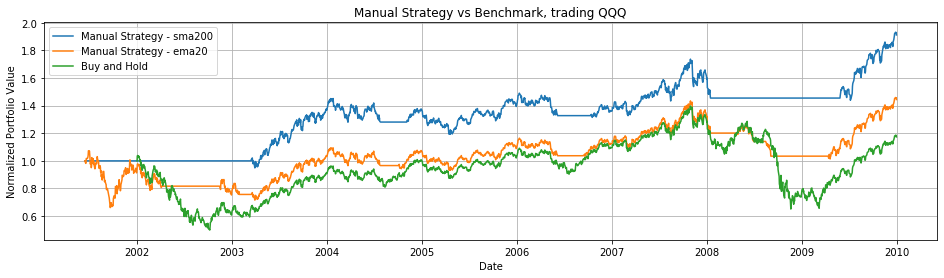

In [8]:
fig = plt.figure(figsize=(16,4))
plt.plot(ms_port_val_os.index, ms_port_val_os.closing_value/ms_port_val_os.closing_value.iloc[0], label='Manual Strategy - sma200')
plt.plot(ms_port_val_os.index, ms_port_val_os2.closing_value/ms_port_val_os2.closing_value.iloc[0], label='Manual Strategy - ema20')
plt.plot(bm_port_val_os.index, bm_port_val_os.closing_value/bm_port_val_os.closing_value.iloc[0], label='Buy and Hold')

plt.legend()
plt.grid(True)
plt.title('Manual Strategy vs Benchmark, trading {}'.format(symbol))
plt.xlabel('Date')
plt.ylabel('Normalized Portfolio Value')



Text(0, 0.5, 'Normalized Portfolio Value')

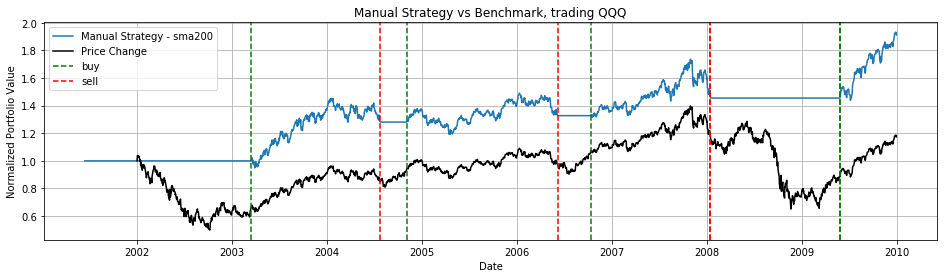

In [9]:
fig = plt.figure(figsize=(16,4))
plt.plot(ms_port_val_os.index, ms_port_val_os.closing_value/ms_port_val_os.closing_value.iloc[0], label='Manual Strategy - sma200')
# plt.plot(ms_port_val_os.index, ms_port_val_os2.closing_value/ms_port_val_os2.closing_value.iloc[0], label='Manual Strategy - ema20')
plt.plot(bm_port_val_os.index, bm_port_val_os.closing_value/bm_port_val_os.closing_value.iloc[0], label='Price Change', color='black')


#plt.plot(ms_port_val_os.index, df_indicators['price_to_sma200'], label='price_to_sma200', color='black')

xcoords = ms_trade_os.loc[ms_trade_os[trade_col_name]>0].index
for xc in xcoords:
    plt.axvline(x=xc, color = 'green', linestyle='dashed') 
plt.axvline(x=xc, color = 'green', linestyle='dashed', label='buy') 

    
xcoords = ms_trade_os.loc[ms_trade_os[trade_col_name]<0].index
for xc in xcoords:
    plt.axvline(x=xc, color = 'red', linestyle='dashed') 
plt.axvline(x=xc, color = 'red', linestyle='dashed', label='sell') 
    
plt.legend()
plt.grid(True)
plt.title('Manual Strategy vs Benchmark, trading {}'.format(symbol))
plt.xlabel('Date')
plt.ylabel('Normalized Portfolio Value')



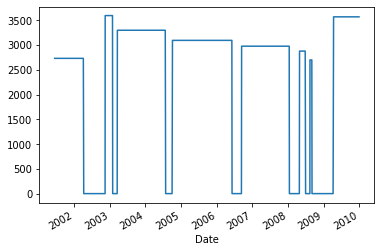

In [10]:
ms_port_val_os2.quantity.plot()

In [11]:
### testing on a longer duration

symbol = "QQQ"
ticker = "QQQ"
sd=dt.datetime(2002, 1, 1)
ed=dt.datetime(2020, 1, 1)
commission = 0
impact = 0
sv = 100000
verbose = False
trade_col_name='trade'

bm_trade_os = benchmark_trade(  
        symbol=symbol,  		  	   		     		  		  		    	 		 		   		 		  
        sd=sd,  		  	   		     		  		  		    	 		 		   		 		  
        ed=ed,  		  	   		     		  		  		    	 		 		   		 		   
        max_holdings=1  		  	   		     		  		  		    	 		 		   		 		  
)
#bm_port_val_os = compute_portvals(bm_trade_os,  start_val=sv, commission=commission,  impact=impact)
bm_port_val_os = get_portvals(bm_trade_os,  start_val=sv, trade_col_name='trade')#, commission=commission,  impact=impact)


rc, ar, sr = get_stats(bm_port_val_os['closing_value'])
print("""Performance of Benchmark: 
cumulative return:{:.2%}, 
average of daily return:{:.8f}, 
std of daily return: {:.8f}
""".format(rc, ar, sr))

mslearner = ManualStrategy(commission = commission, impact = impact)

policy = 'sma200'
ms_trade_os = mslearner.testPolicy(symbol = symbol, 
                                    sd=sd,
                                    ed=ed,
                                    sv = 100000, policy = policy)

# ms_port_val_os = compute_portvals(ms_trade_os,  start_val=sv, commission=commission,  impact=impact)
ms_port_val_os = get_portvals(ms_trade_os,  start_val=sv)
rc, ar, sr = get_stats(ms_port_val_os['closing_value'])

print("""Performance of Strategy {}: 
    cumulative return:{:.2%}, 
    average of daily return:{:.8f}, 
    std of daily return: {:.8f}
    """.format(policy, rc, ar, sr))


policy = 'ema20'
ms_trade_os2 = mslearner.testPolicy(symbol = symbol, 
                                    sd=sd,
                                    ed=ed,
                                    sv = 100000, policy = policy)

# ms_port_val_os = compute_portvals(ms_trade_os,  start_val=sv, commission=commission,  impact=impact)
ms_port_val_os2 = get_portvals(ms_trade_os2,  start_val=sv)
rc, ar, sr = get_stats(ms_port_val_os2['closing_value'])

print("""Performance of Strategy {}: 
    cumulative return:{:.2%}, 
    average of daily return:{:.8f}, 
    std of daily return: {:.8f}
    """.format(policy, rc, ar, sr))


[*********************100%***********************]  1 of 1 completed


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Performance of Benchmark: 
cumulative return:505.57%, 
average of daily return:0.00049275, 
std of daily return: 0.01379933

[*********************100%***********************]  1 of 1 completed
Performance of Strategy sma200: 
    cumulative return:400.21%, 
    average of daily return:0.00038350, 
    std of daily return: 0.00873808
    
[*********************100%***********************]  1 of 1 completed
Performance of Strategy ema20: 
    cumulative return:331.94%, 
    average of daily return:0.00037384, 
    std of daily return: 0.01094920
    


Text(0, 0.5, 'Normalized Portfolio Value')

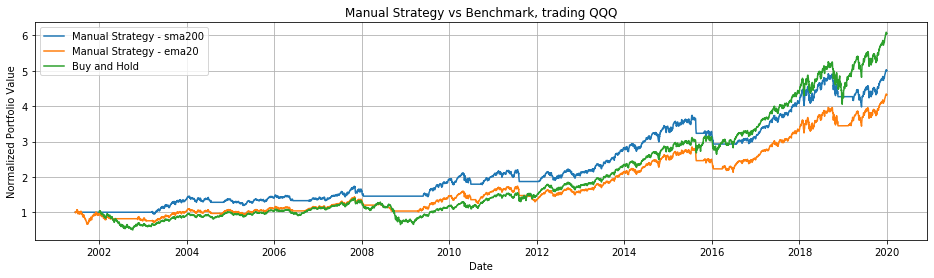

In [12]:
fig = plt.figure(figsize=(16,4))
plt.plot(ms_port_val_os.index, ms_port_val_os.closing_value/ms_port_val_os.closing_value.iloc[0], label='Manual Strategy - sma200')
plt.plot(ms_port_val_os.index, ms_port_val_os2.closing_value/ms_port_val_os2.closing_value.iloc[0], label='Manual Strategy - ema20')
plt.plot(bm_port_val_os.index, bm_port_val_os.closing_value/bm_port_val_os.closing_value.iloc[0], label='Buy and Hold')

plt.legend()
plt.grid(True)
plt.title('Manual Strategy vs Benchmark, trading {}'.format(symbol))
plt.xlabel('Date')
plt.ylabel('Normalized Portfolio Value')



Text(0, 0.5, 'Normalized Portfolio Value')

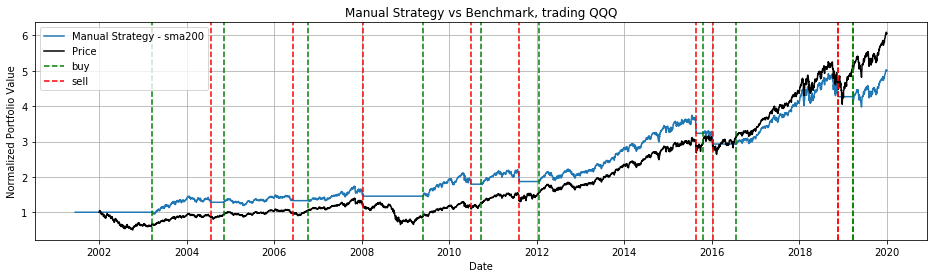

In [13]:
fig = plt.figure(figsize=(16,4))
plt.plot(ms_port_val_os.index, ms_port_val_os.closing_value/ms_port_val_os.closing_value.iloc[0], label='Manual Strategy - sma200')
# plt.plot(ms_port_val_os.index, ms_port_val_os2.closing_value/ms_port_val_os2.closing_value.iloc[0], label='Manual Strategy - ema20')
plt.plot(bm_port_val_os.index, bm_port_val_os.closing_value/bm_port_val_os.closing_value.iloc[0], label='Price', color='black')


#plt.plot(ms_port_val_os.index, df_indicators['price_to_sma200'], label='price_to_sma200', color='black')

xcoords = ms_trade_os.loc[ms_trade_os[trade_col_name]>0].index
for xc in xcoords:
    plt.axvline(x=xc, color = 'green', linestyle='dashed') 
plt.axvline(x=xc, color = 'green', linestyle='dashed', label='buy') 

    
xcoords = ms_trade_os.loc[ms_trade_os[trade_col_name]<0].index
for xc in xcoords:
    plt.axvline(x=xc, color = 'red', linestyle='dashed') 
plt.axvline(x=xc, color = 'red', linestyle='dashed', label='sell') 
    
plt.legend()
plt.grid(True)
plt.title('Manual Strategy vs Benchmark, trading {}'.format(symbol))
plt.xlabel('Date')
plt.ylabel('Normalized Portfolio Value')



In [14]:
### testing on a longer duration

symbol = "QQQ"
ticker = "QQQ"
sd=dt.datetime(2002, 1, 1)
ed=dt.datetime(2023, 2, 11)
commission = 0
impact = 0
sv = 100000
verbose = False
trade_col_name='trade'

bm_trade_os = benchmark_trade(  
        symbol=symbol,  		  	   		     		  		  		    	 		 		   		 		  
        sd=sd,  		  	   		     		  		  		    	 		 		   		 		  
        ed=ed,  		  	   		     		  		  		    	 		 		   		 		   
        max_holdings=1  		  	   		     		  		  		    	 		 		   		 		  
)
#bm_port_val_os = compute_portvals(bm_trade_os,  start_val=sv, commission=commission,  impact=impact)
bm_port_val_os = get_portvals(bm_trade_os,  start_val=sv, trade_col_name='trade')#, commission=commission,  impact=impact)


rc, ar, sr = get_stats(bm_port_val_os['closing_value'])
print("""Performance of Benchmark: 
cumulative return:{:.2%}, 
average of daily return:{:.8f}, 
std of daily return: {:.8f}
""".format(rc, ar, sr))

mslearner = ManualStrategy(commission = commission, impact = impact)

policy = 'sma200'
ms_trade_os = mslearner.testPolicy(symbol = symbol, 
                                    sd=sd,
                                    ed=ed,
                                    sv = 100000, policy = policy)

# ms_port_val_os = compute_portvals(ms_trade_os,  start_val=sv, commission=commission,  impact=impact)
ms_port_val_os = get_portvals(ms_trade_os,  start_val=sv)
rc, ar, sr = get_stats(ms_port_val_os['closing_value'])

print("""Performance of Strategy {}: 
    cumulative return:{:.2%}, 
    average of daily return:{:.8f}, 
    std of daily return: {:.8f}
    """.format(policy, rc, ar, sr))


policy = 'ema20'
ms_trade_os2 = mslearner.testPolicy(symbol = symbol, 
                                    sd=sd,
                                    ed=ed,
                                    sv = 100000, policy = policy)

# ms_port_val_os = compute_portvals(ms_trade_os,  start_val=sv, commission=commission,  impact=impact)
ms_port_val_os2 = get_portvals(ms_trade_os2,  start_val=sv)
rc, ar, sr = get_stats(ms_port_val_os2['closing_value'])

print("""Performance of Strategy {}: 
    cumulative return:{:.2%}, 
    average of daily return:{:.8f}, 
    std of daily return: {:.8f}
    """.format(policy, rc, ar, sr))


[*********************100%***********************]  1 of 1 completed


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Performance of Benchmark: 
cumulative return:768.98%, 
average of daily return:0.00051365, 
std of daily return: 0.01460601

[*********************100%***********************]  1 of 1 completed
Performance of Strategy sma200: 
    cumulative return:558.85%, 
    average of daily return:0.00038958, 
    std of daily return: 0.00930458
    
[*********************100%***********************]  1 of 1 completed
Performance of Strategy ema20: 
    cumulative return:440.19%, 
    average of daily return:0.00037200, 
    std of daily return: 0.01114593
    


Text(0, 0.5, 'Normalized Portfolio Value')

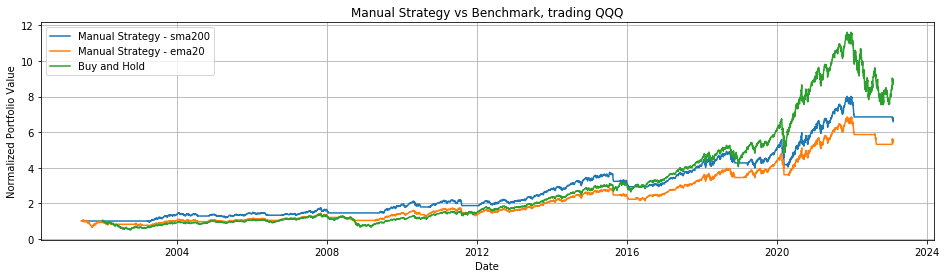

In [15]:
fig = plt.figure(figsize=(16,4))
plt.plot(ms_port_val_os.index, ms_port_val_os.closing_value/ms_port_val_os.closing_value.iloc[0], label='Manual Strategy - sma200')
plt.plot(ms_port_val_os.index, ms_port_val_os2.closing_value/ms_port_val_os2.closing_value.iloc[0], label='Manual Strategy - ema20')
plt.plot(bm_port_val_os.index, bm_port_val_os.closing_value/bm_port_val_os.closing_value.iloc[0], label='Buy and Hold')

plt.legend()
plt.grid(True)
plt.title('Manual Strategy vs Benchmark, trading {}'.format(symbol))
plt.xlabel('Date')
plt.ylabel('Normalized Portfolio Value')



Text(0, 0.5, 'Normalized Portfolio Value')

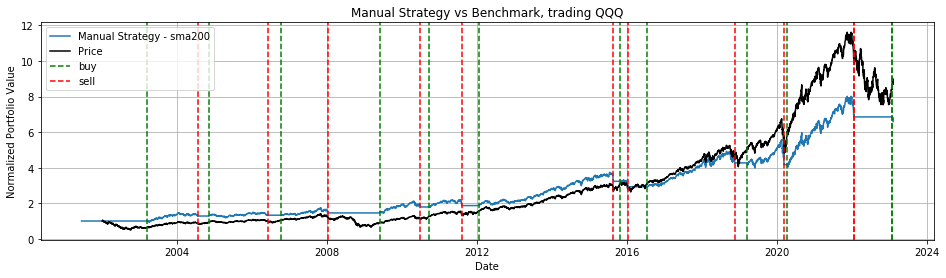

In [16]:
fig = plt.figure(figsize=(16,4))
plt.plot(ms_port_val_os.index, ms_port_val_os.closing_value/ms_port_val_os.closing_value.iloc[0], label='Manual Strategy - sma200')
# plt.plot(ms_port_val_os.index, ms_port_val_os2.closing_value/ms_port_val_os2.closing_value.iloc[0], label='Manual Strategy - ema20')
plt.plot(bm_port_val_os.index, bm_port_val_os.closing_value/bm_port_val_os.closing_value.iloc[0], label='Price', color='black')


#plt.plot(ms_port_val_os.index, df_indicators['price_to_sma200'], label='price_to_sma200', color='black')

xcoords = ms_trade_os.loc[ms_trade_os[trade_col_name]>0].index
for xc in xcoords:
    plt.axvline(x=xc, color = 'green', linestyle='dashed') 
plt.axvline(x=xc, color = 'green', linestyle='dashed', label='buy') 

    
xcoords = ms_trade_os.loc[ms_trade_os[trade_col_name]<0].index
for xc in xcoords:
    plt.axvline(x=xc, color = 'red', linestyle='dashed') 
plt.axvline(x=xc, color = 'red', linestyle='dashed', label='sell') 
    
plt.legend()
plt.grid(True)
plt.title('Manual Strategy vs Benchmark, trading {}'.format(symbol))
plt.xlabel('Date')
plt.ylabel('Normalized Portfolio Value')

